# LLM-Knowledge

This is a handbook with all necessary knowledge about chatgpt and other LLMs for GeneRXN. 

## Chatgpt related pratical tips

### 1. Token limits

#### 1.1 What is a token for gpt and how do we count in real use

**What is a token** : Token is a concept in natural language which we use to break down a sentence into meta units, including words, punctuation marks... Depending on the tokenizing techniques used, a word can also be further broken down into prefix and postfix etc. According to Openai the approximation for tokens is: 
* 1 token ~= 4 chars in English

* 1 token ~= ¾ words

* 100 tokens ~= 75 words

Or 

* 1-2 sentence ~= 30 tokens

* 1 paragraph ~= 100 tokens

* 1,500 words ~= 2048 tokens 

#### 1.2 Token limitaions 

* **The limitation is shared between prompt and completion**. Prompt is your input and the completion is the answer from chatgpt. If you have a token limitation up to 4096 and your prompt is 4000 tokens, your completion can be 97 tokens at most. 

* Both input and output tokens count toward these quantities. For example, if your API call used 10 tokens in the message input and you received 20 tokens in the message output, you would be billed for 30 tokens.

* To see how many tokens are used by an API call, check the usage field in the API response (e.g., response['usage']['total_tokens']).

* Token limitations for different models

|     Model     | Maximum Tokens |
|:-------------:|:--------------:|
| gpt-3.5-turbo |  4,096 tokens  |
|     gpt-4     |  8,192 tokens  |
|   gpt-4-32k   |  32,768 tokens |

#### 1.3 Token pricing

* This is obtained from [Openai website](https://openai.com/pricing)

|     Model     |       Prompt       |     Completion     |
|:-------------:|:------------------:|:------------------:|
| gpt-3.5-turbo | $0.002 / 1K tokens | $0.002 / 1K tokens |
|     gpt-4     |  $0.03 / 1K tokens |  $0.06 / 1K tokens |
|   gpt-4-32k   |  $0.06 / 1K tokens |  $0.12 / 1K tokens |


### 2. Memory retenant (chat history preservation)

Think in this way, a model is basically a huge chunk of math calculations, therefore **there is no memory for the model**. Chatgpt and other chat bots use certain techniques to make chatgpt feel like it remember the previous chat history. One way to achieve that is by **feeding the previous messages to GPT**. To be more detailed, every single time we send a request to GPT, we have to firstly collect the chat log, attach the current prompt to it and then feed it to the model (Which is indeed inefficient when the conversation goes on and on).

An example is shown below, which is from the repo [here](https://github.com/atomic14/command_line_chatgpt/blob/main/main.py).
**The general logic is feeding the model the general context first, then every single time the model is fed by the combination of the chat log and current prompt.**

In [ ]:
def get_response(instructions, previous_questions_and_answers, new_question):
    """Get a response from ChatCompletion

    Args:
        instructions: The instructions for the chat bot - this determines how it will behave
        previous_questions_and_answers: Chat history
        new_question: The new question to ask the bot

    Returns:
        The response text
    """
    messages = [
        { "role": "system", "content": instructions },
    ]
    # add the previous questions and answers
    for question, answer in previous_questions_and_answers[-MAX_CONTEXT_QUESTIONS:]:
        messages.append({ "role": "user", "content": question })
        messages.append({ "role": "assistant", "content": answer })
    # add the new question
    messages.append({ "role": "user", "content": new_question })

    completion = openai.ChatCompletion.create(
        model="gpt-3.5-turbo",
        messages=messages,
        temperature=TEMPERATURE,
        max_tokens=MAX_TOKENS,
        top_p=1,
        frequency_penalty=FREQUENCY_PENALTY,
        presence_penalty=PRESENCE_PENALTY,
    )
    return completion.choices[0].message.content

### 3. Work around token limitations

* We human do not need to remember every word in the conversation. Similar to which, we do not need to provide the exact dialog to the model. To save the space in each request, we can have a brief summary of what happened in the previous conversation and provide it to the model as context which is called **Information Condensation**.

* A helpful library is [langchain](https://python.langchain.com/en/latest/index.html). Check the libraries [**ConversationSummaryMemory**](https://python.langchain.com/en/latest/modules/memory/types/summary.html) and [**ConversationSummaryBufferMemory**](https://python.langchain.com/en/latest/modules/memory/types/summary_buffer.html) out for details.


### 4. In context learning (ICL)

#### 4.1 What is in context learning (ICL)? How can it help?

In-context learning is a few shot learning technique which exclusively happens in Large Language Models of a certain size. During in-context learning, we give the LM a prompt that consists of a list of input-output pairs that demonstrate a task. At the end of the prompt, we append a test input and allow the LM to make a prediction just by conditioning on the prompt and predicting the next tokens. To correctly answer the two prompts below, the model needs to read the training examples to figure out the input distribution (financial or general news), output distribution (Positive/Negative or topic), input-output mapping (sentiment or topic classification), and the formatting. Two examples are shown below:

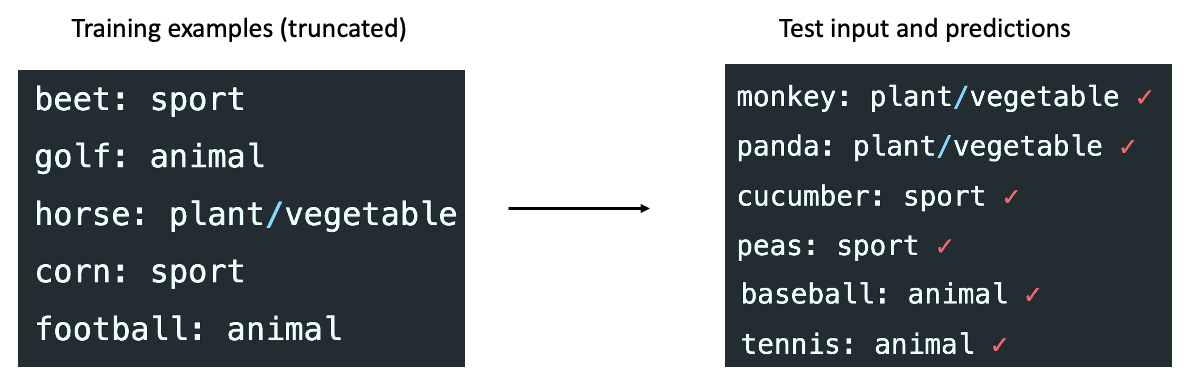

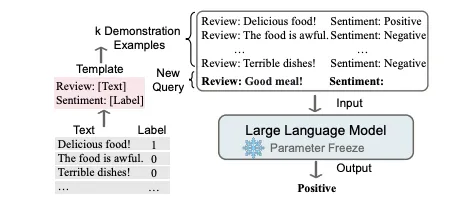

A few things should be highlighted that:

* This is not an actual learning, **the model weights are frozen and do not need to be updated**.

* Since the procedure takes the prompt containing input and output mappings, **the limited input space will be further reduced**. Let's say for GPT-3.5 turbo model, we have the input space limited to 4096 tokens which containing both inputs (prompts) and output (completion by the model). If we have a few input output mappings to practice ICL on the model, the prompt used in the procedure takes the space away from the total input space.


#### 4.2 Examples for ICL

**Entity Recognition** : which can be used to extract the most important information from a document.

The input for ICL is:

```
[Text]: Microsoft was founded by Bill Gates on April 4, 1975. The current CEO of Microsoft is Satya Nadella.
[Name] : Satya Nadella
[Position]: CEO
[Company]: Microsoft
###
[Text]: Tim Cook became the CEO of Apple after Steve Jobs resigned as the CEO citing health reasons.
[Name]: Tim Cook
[Position]: CEO
[Company]: Apple
###
[Text]: Demis Hassabis is the CEO of DeepMind which was acquired by Google in 2014.
```

The output by the model will be:

```
[Name] : Demis Hassabis
[Position]: CEO
[Company]: DeepMind
###
```

**SQL Code Completion** : this can be used to generate SQL code to interact with our database.

The input for ICL is:

```
Question: Fetch the companies that have less than five people in it.
Answer: SELECT COMPANY, COUNT(EMPLOYEE_ID) FROM Employee GROUP BY COMPANY HAVING COUNT(EMPLOYEE_ID) < 5;
###
Question: Show all companies along with the number of employees in each department
Answer: SELECT COMPANY, COUNT(COMPANY) FROM Employee GROUP BY COMPANY;
###
Question: Show the last record of the Employee table
Answer: SELECT * FROM Employee ORDER BY LAST_NAME DESC LIMIT 1;
###
Question: Fetch three employees from the Employee table
```

The output by the model will be:

```
Answer: SELECT * FROM Employee ORDER BY LAST_NAME ASC LIMIT 3;
```

#### 4.3 Tricks for ICL

**Input-output pairing in the prompt matters much less than previously thought**

##### Comparing three methods:

* **No-examples**: the LM conditions on the test input only, with no examples. This is typical zero-shot inference, first done by GPT-2/GPT-3.

* **Examples with ground truth outputs**: the LM conditions on the concatenation of a few in-context examples and the test input. This is a typical in-context learning method, and by default, all outputs in the prompt are ground truth.

* **Examples with random outputs**: the LM conditions on in-context examples and the test input, but now, each output in the prompt is randomly sampled from the output set (labels in the classification tasks; a set of answer options in the multi-choice tasks).

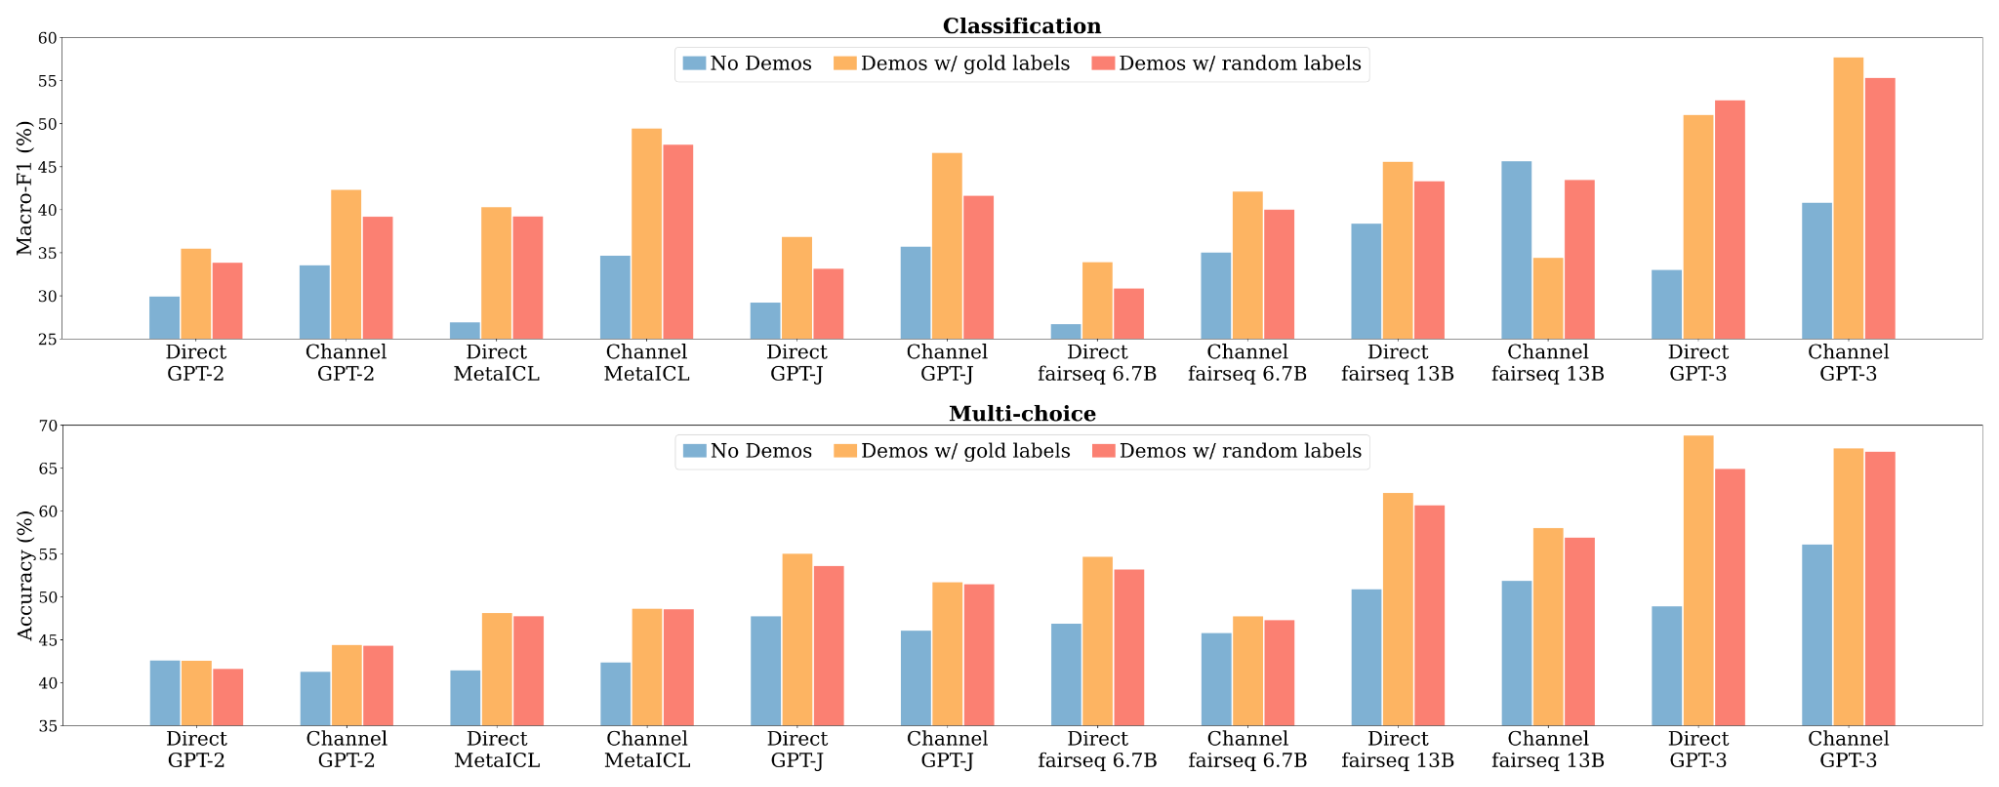


#### 4.4 Theories

#### Reference List
[1] http://ai.stanford.edu/blog/understanding-incontext/
[2] https://medium.com/@mlblogging.k/understanding-in-context-learning-in-large-language-models-like-gpt3-gpt-j-gptneox-e0a71063a6db